# Model Building - Predicting Departure Delays

Now that we have a continuous source of data that is labeled, we can attempt to

> Build a model that **predicts the probability of a departing flight delaying**

Our attempt will use an XGBoost classification model, given the amount of data we have, and the features that we will using, it seems like it's can bring the highest predictive power with a relatively lower amount of effort. 

In this notebook, we will:
- Clearly define what our problem is and setup evaluation metrics
- Load in data from BigQuery and clean out anomalies
- Build a model with XGBoost
- Evaluate the model against our evaluation metrics
- Tune the model to reach a statisfactory threshold for metrics

Once these are completed, the model can be saved into a repository (manual) and used for predictions for upcoming flights. This will be done in ```predict.ipynb```.

In [251]:
# Google modules for reading the from BigQuery
from google.cloud import bigquery
from google.oauth2 import service_account

import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
%matplotlib inline


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix


import pickle
from datetime import datetime, date

## Defining the Problem

It's clear that we're trying to predict if a departing flight will be delayed, but **what counts as being *delayed***? According to the Federal Aviation Administration:

> A flight is delayed when it is **15 minutes later** than its scheduled time

We'll go with this definition, presuming that when there are costs involved with flight delays,airlines will go with this official definition. 


## Building a Hypothesis - What are the features we should use?
So what are the features we will be using? Based on [previous studies](https://www.mdpi.com/2226-4310/8/8/212) from College of Civil Aviation, Nanjing University of Aeronautics and Astronautics [1], it seems as though the delays are largely impacted by **arrival delays from previous flights.** Other features I came up with, and weighing the extra time/costs involved in data collection, I have decided in using the following features:

|   Field   |   Description             |
|-----------|---------------            |
|dep_hour     |Hour of departure          |
|dep_weekday  |Day of week for departure  |
|prev_arr_hour|Hour of arrival of previous flight|
|prev_arr_weekday|Day of week of previous flight|
|scheduled_turnaround|Minutes between scheduled arrival and scheduled departure|
|actual_turnaround|Mintues between actual arrival and actual departure|
|destination|Country id of arrival|
|cargo|Boolean for whether it is a cargo flight|
|iata|IATA code of airline|
|fleet_size| Number of fleets the airline owns|
|route_flight_options|Number of unique flight numbers of same type with the same route on the same day|
|route_airline_options|Number of unique airlines with the same route on the same day|
|delayed | Boolean response variable|

Important to note that we define

> The previous arrival flight is the last flight of the same type(cargo/PAX), same lane, same airline that, arrived no farther than one week before scheduled departure and no earlier than [30 minutes before scheduled departure](http://aviationavi.com/turn-around-time-tat/#:~:text=The%20duration%20of%20the%20turnaround,is%20usually%20about%20an%20hour).

Which meant that the fields with previous arrival flights could very much be null if there isn't a corresponding flight. Such a defintion sits on the assumption that

> Flights are only bidirectional, that a flight from A->B would *only* return the same way from B->A.

In reality this may not always be the case, but in our study if a flight could not be found, it will be mapped to null, which the model could also weigh in on potentially. 

<img src="https://www.mdpi.com/aerospace/aerospace-08-00212/article_deploy/html/images/aerospace-08-00212-g001-550.jpg">

(Image directly from Zheng, 2021)

[1] *Zheng, Zhe, Wenbin Wei, and Minghua Hu. 2021. "A Comparative Analysis of Delay Propagation on Departure and Arrival Flights for a Chinese Case Study" Aerospace 8, no. 8: 212. https://doi.org/10.3390/aerospace8080212*

## Extracting Data - And observations...

Now that we have a collection of data in BigQuery, the data is **stitched together with SQL** first in a view set in BigQuery. This will mean we can forgo the majority of data combination, and focus more on cleaning what's on hand and training the model with.


In [126]:
# Set up bigquery selection
key_path = r"./bq_key.json"

credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

client = bigquery.Client(credentials=credentials, project=credentials.project_id,)

In [127]:
df = client.query("""
                        SELECT * FROM flights.training_main
                        """).to_dataframe()

df.sample(5).T #Easier to see transposed

,2302,14202,15598,10042,648
prev_arr_hour,21,6,<NA>,23,<NA>
prev_arr_weekday,4,3,<NA>,5,<NA>
dep_hour,23,7,1,10,13
dep_weekday,4,3,6,4,5
scheduled_turnaround,120,80,<NA>,7825,<NA>
actual_turnaround,92,105,<NA>,7861,<NA>
destination,DOH,SZB,YVR,KIX,KHH
iata,QR,TH,CX,CX,UO
fleet_size,244,5,173,173,26
cargo,1,1,0,0,0


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15614 entries, 0 to 15613
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   prev_arr_hour          11249 non-null  Int64  
 1   prev_arr_weekday       11249 non-null  Int64  
 2   dep_hour               15614 non-null  Int64  
 3   dep_weekday            15614 non-null  Int64  
 4   scheduled_turnaround   11249 non-null  float64
 5   actual_turnaround      11249 non-null  float64
 6   destination            15614 non-null  object 
 7   iata                   15614 non-null  object 
 8   fleet_size             15614 non-null  Int64  
 9   cargo                  15614 non-null  Int64  
 10  route_flight_options   15614 non-null  Int64  
 11  route_airline_options  15614 non-null  Int64  
 12  delayed                15614 non-null  Int64  
dtypes: Int64(9), float64(2), object(2)
memory usage: 1.7+ MB


In [128]:
# casting to float to allow for pd.describe() to work with np.nan more reliably
df[['scheduled_turnaround', 'actual_turnaround']] = df[
                                                ['scheduled_turnaround', 'actual_turnaround']
                                                ].astype(float)

In [129]:
# basic df summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
prev_arr_hour,11249.0,10.402702,7.269378,0.0,3.0,11.0,17.0,23.0
prev_arr_weekday,11249.0,4.243577,2.041458,1.0,3.0,4.0,6.0,7.0
dep_hour,15614.0,12.181376,6.488190,0.0,7.0,12.0,18.0,23.0
dep_weekday,15614.0,4.186371,1.988464,1.0,3.0,4.0,6.0,7.0
scheduled_turnaround,11249.0,1455.748422,2056.418670,35.0,130.0,765.0,1725.0,10040.0
actual_turnaround,11249.0,1468.818917,2061.462357,31.0,128.0,764.0,1757.0,10071.0
fleet_size,15614.0,123.702382,144.768512,1.0,14.0,92.0,173.0,1441.0
cargo,15614.0,0.727040,0.445495,0.0,0.0,1.0,1.0,1.0
route_flight_options,15614.0,12.311067,9.508137,1.0,4.0,10.0,19.0,44.0
route_airline_options,15614.0,5.392789,3.622008,1.0,2.0,5.0,8.0,16.0


In [131]:
# how many flights have a previous arrival flight?
df['prev_arr_hour'].notnull().value_counts()

True     11249
False     4365
Name: prev_arr_hour, dtype: int64

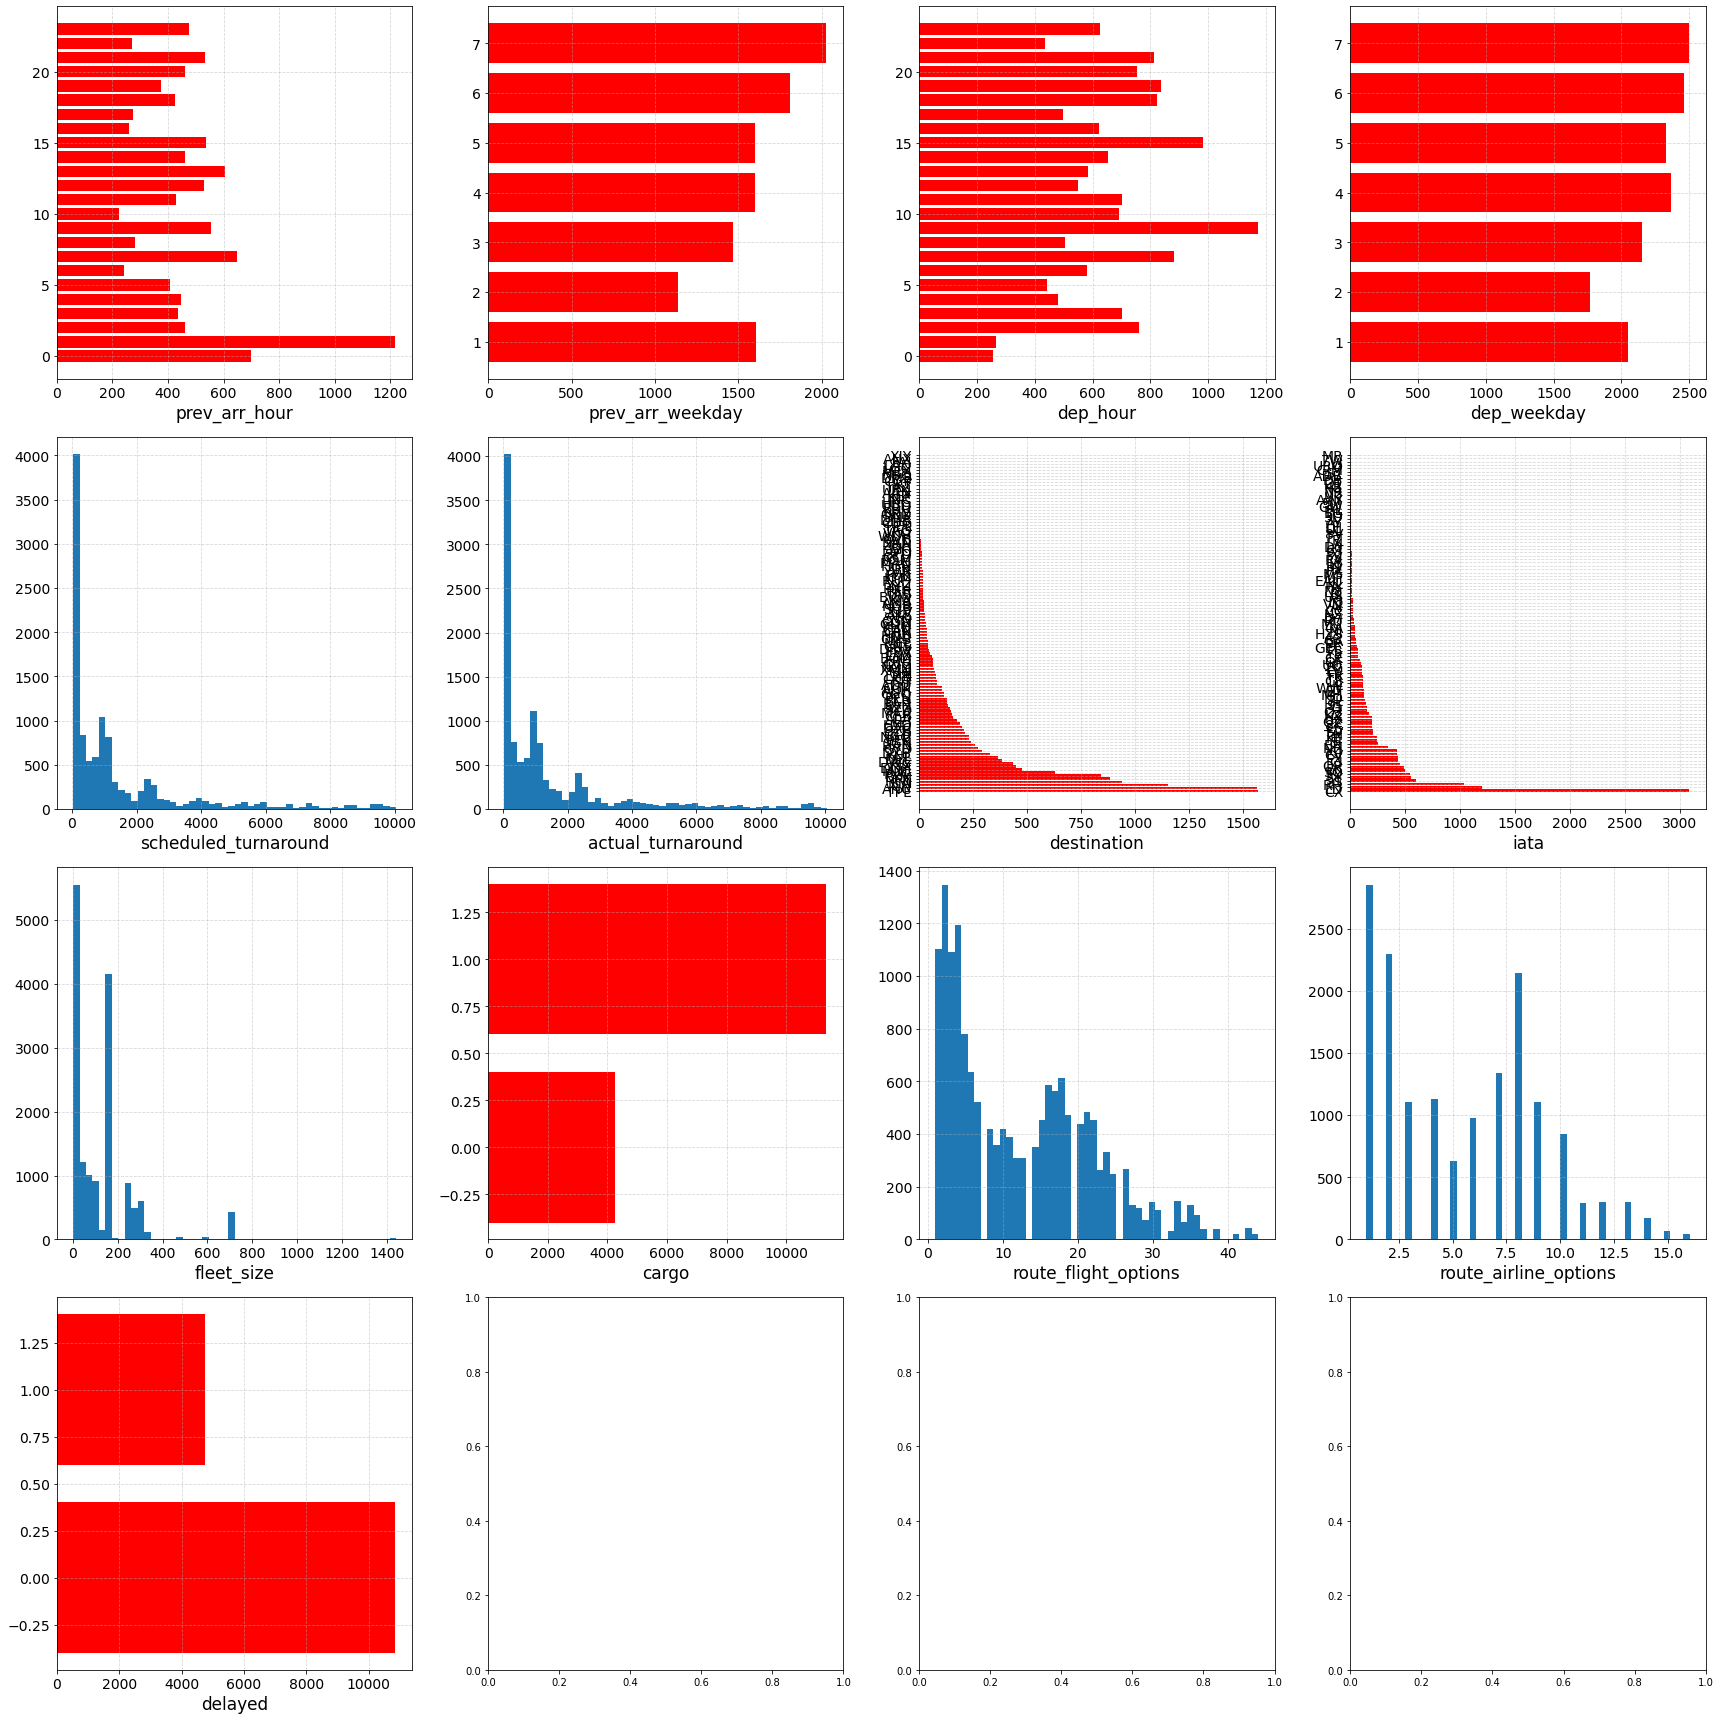

In [152]:
# Plotting the distributions of variables
attribute_number = len(df.columns)

# Attribute plot type
plot_type = {
    'prev_arr_hour':'bar_i', 'prev_arr_weekday':'bar_i', 'dep_hour':'bar_i', 'dep_weekday':'bar_i',
       'scheduled_turnaround':'hist', 'actual_turnaround':'hist', 'destination':'bar', 'iata':'bar',
       'fleet_size':'hist', 'cargo':'bar_i', 'route_flight_options':'hist', 'route_airline_options':'hist',
       'delayed':'bar_i'
}

# subplots 
fig = plt.figure(figsize=(24, 24))
ax = fig.subplots(attribute_number//4+1,4)
# iterations
for num, title in enumerate(df.columns):
    idx = num//4 # divided with no remainder
    idy = num%4  # remainder 
    if plot_type[title] == 'bar':
        value_count_dict = df[title].value_counts().to_dict()
        keys = list(value_count_dict.keys())
        values = list(value_count_dict.values())
        ax[idx, idy].barh(keys, values, color='r')

    elif plot_type[title] == 'bar_i':
        value_count_dict = df[title].value_counts().to_dict()
        keys = list(value_count_dict.keys())
        values = list(value_count_dict.values())
        ax[idx, idy].barh(keys, values, color='r')

    else:
        ax[idx, idy].hist(df[title].values, bins=50);
    
    # set title with attribute
    ax[idx, idy].set_xlabel(title, fontsize=17)
    # set grid width
    ax[idx, idy].grid(linestyle='--', alpha=0.5)
    # font size of ticks
    ax[idx, idy].tick_params(labelsize=14)
plt.tight_layout()

The attributes *looks* well dsitributed i.e. it does not seem like there are anomalies present that are out of the ordinary. Though there are clearly skewness to the turnaround minutes, this is as expected and the distribution is bounded by a search domain of previous arrival belonging to ```[dep-7days, dep-30mins]```, a quasi business rule imposed.

## Building the Model - XGBoost

The process of building a model involves:

1. One-Hot Encode categorical features i.e. IATA and Destination, using ```sklearn.preprocessing```
2. Train-Val-Test split of data, using ```sklearn.preprocessing```
3. Setup Hyperparameters for XGBoost
4. Fit model based on AUC
5. Model Evaluation
6. Hyperparameters tuning with ```sklearn.model_selection.RandomSearchCV``` and ```sklearn.model_selection.GridSearchCV```
7. Save Model, Encoder via pickle

### One-Hot Encoding for IATA and Destination

Every training, we initialize a new encoder for IATA and destination. This will be used again during inference. The key is to have ```handle_unknown="ignore"``` to account for new destinations in unseen during training.

In [174]:
# Initialisse an Encoder
iata_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
iata_encoder.fit(np.array(df['iata']).reshape(-1, 1))

dest_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
dest_encoder.fit(np.array(df['destination']).reshape(-1, 1))

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [175]:
# check in case it's not right
print(f"IATA Values:", iata_encoder.categories_[0][:5], "...")
print(f"Destination Values:",dest_encoder.categories_[0][:5], "...")

IATA Values: ['3D' '3S' '3V' '4B' '5J'] ...
Destination Values: ['AAN' 'ADD' 'AKL' 'ALA' 'AMS'] ...


In [187]:
# get encoded columns
iata_OHE = pd.DataFrame(iata_encoder.transform(np.array(df['iata']).reshape(-1, 1)))
iata_OHE.columns = [f'iata_{x}' for x in iata_OHE.columns]

dest_OHE = pd.DataFrame(dest_encoder.transform(np.array(df['destination']).reshape(-1, 1)))
dest_OHE.columns = [f'dest_{x}' for x in dest_OHE.columns]

In [196]:
data = pd.concat([df, iata_OHE, dest_OHE], axis=1
                ).drop(columns=['iata', 'destination']).fillna(np.nan)

print(f"Data Shape: {data.shape}")
data.head()

Data Shape: (15614, 223)


,prev_arr_hour,prev_arr_weekday,dep_hour,dep_weekday,scheduled_turnaround,actual_turnaround,fleet_size,cargo,route_flight_options,route_airline_options,...,dest_101,dest_102,dest_103,dest_104,dest_105,dest_106,dest_107,dest_108,dest_109,dest_110
0,<NA>,<NA>,10,4,NaN,NaN,7,1,9,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20,1,15,4,3990.0,4376.0,5,1,10,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,11,7,15,4,6035.0,6475.0,80,1,7,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,4,20,4,1175.0,1673.0,5,1,5,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,18,4,20,4,120.0,113.0,5,1,6,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Setting Up Train-Val-Test Split

We will be splitting the data in 70%-15%-15%, a common split. The key here is to make sure we set ```stratify=y``` to ensure the same distribution for responses between the datasets.

In [204]:
X = data.astype(float).drop(columns = ['delayed']) 
y = data.astype(float)['delayed']

# split train-test by 70%-30%
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    shuffle=True, stratify=y)


# split val-test to 15%-15%
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, 
                                                    test_size=0.5,
                                                    shuffle=True, stratify=y_test)
                            

# using a DMatrix is better practice for xgboost
dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.NaN)
dval = xgb.DMatrix(X_val, label=y_val, missing=np.NaN)
dtest = xgb.DMatrix(X_test, label=y_test, missing=np.NaN)

print('X_train:  {} || y_train:  {} || positive_rate: {:.3f}'.format(
        X_train.shape, y_train.shape, np.sum(y_train)/len(y_train)))

print('X_val : {} || y_val: {} || positive_rate: {:.3f}'.format(
        X_val.shape, y_val.shape, np.sum(y_val)/len(y_val)))

print('X_test: {} || y_test: {} || positive_rate: {:.3f}'.format(
        X_test.shape, y_test.shape, np.sum(y_test)/len(y_test)))

X_train:  (10929, 222) || y_train:  (10929,) || positive_rate: 0.304
X_val : (2342, 222) || y_val: (2342,) || positive_rate: 0.304
X_test: (2343, 222) || y_test: (2343,) || positive_rate: 0.304


### Initial Training - Hyperparameters

Before we tune any hyperparameters, we can start off with a set of hyperparameters that are commonly used. Once we get a basic idea of accuracy, we can start tuning based the search methods.

In [212]:
param = {'max_depth': 8, 
        'eta': 0.12, 
        'objective': 'binary:logistic', 
        'lambda': 100, 
        'colsample_bytree': 0.75,
        'eval_metric': 'auc',
        'scale_pos_weight': 0.304,
        }

num_round = 1000
early_stopping_rounds = 50

In [213]:
bst = xgb.train(param, dtrain, num_round, 
                early_stopping_rounds=early_stopping_rounds,
                evals=[(dtrain, 'Train'), (dval, 'Valid')],
                verbose_eval=True)


[0]	Train-auc:0.65934	Valid-auc:0.65276
[1]	Train-auc:0.66598	Valid-auc:0.65836
[2]	Train-auc:0.70080	Valid-auc:0.68458
[3]	Train-auc:0.70655	Valid-auc:0.68945
[4]	Train-auc:0.71211	Valid-auc:0.69895
[5]	Train-auc:0.71211	Valid-auc:0.69910
[6]	Train-auc:0.71649	Valid-auc:0.70573
[7]	Train-auc:0.72424	Valid-auc:0.70518
[8]	Train-auc:0.73494	Valid-auc:0.71520
[9]	Train-auc:0.74403	Valid-auc:0.72403
[10]	Train-auc:0.74627	Valid-auc:0.72590
[11]	Train-auc:0.74631	Valid-auc:0.72590
[12]	Train-auc:0.74871	Valid-auc:0.72804
[13]	Train-auc:0.78154	Valid-auc:0.76542
[14]	Train-auc:0.78248	Valid-auc:0.76676
[15]	Train-auc:0.78207	Valid-auc:0.76687
[16]	Train-auc:0.80144	Valid-auc:0.78356
[17]	Train-auc:0.80239	Valid-auc:0.78312
[18]	Train-auc:0.80383	Valid-auc:0.78389
[19]	Train-auc:0.80366	Valid-auc:0.78372
[20]	Train-auc:0.81008	Valid-auc:0.79103
[21]	Train-auc:0.81419	Valid-auc:0.79434
[22]	Train-auc:0.81701	Valid-auc:0.79719
[23]	Train-auc:0.81731	Valid-auc:0.79672
[24]	Train-auc:0.82006	Val

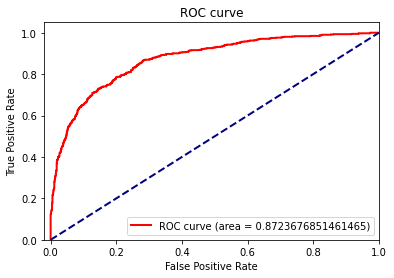

In [216]:
y_pred = bst.predict(dtest)

plt.figure()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='r',
            lw=lw, label=f'ROC curve (area = {roc_auc})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

We have a trained model with a fairly high level for Area Under Curve score. This model currently has 0.87 as the AUC of the ROC curve. These initial hyperparameters will serve as a good ballpark number for our next section of Hyperparameter tuning first with RandomSearchCV.

### Hyperparameter Tuning - RandomSearchCV

The approach we will be using RandomSearchCV to try out a larger range of values in case we spot any better values. 

> Once we've located the best hyperparameters from Random Search to try and catch an even more optimal level, we can use it to fit our new model with.

In [ ]:
# set the hyperparameter range
params = {'max_depth': [4, 6, 8, 10, 12, 14, 16], 
        'eta': [0.05, 0.1, 0.2, 0.4], 
        'lambda': [0, 5, 10, 20, 40, 80, 160], 
        'colsample_bytree': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
        }

xgbr = xgb.XGBRegressor(seed = 20)

clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='roc_auc',
                         n_iter=50,
                         verbose=1)

clf.fit(X_train, y_train)

In [220]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", clf.best_score_)

Best parameters: {'max_depth': 12, 'lambda': 20, 'eta': 0.1, 'colsample_bytree': 0.8}
Lowest RMSE:  0.8644263193142037


Using the new hyperparameters as found from Random Search, we can build the final model with the best performance based on AUC.

In [223]:
param = {'max_depth': 12, 
        'eta': 0.1, 
        'objective': 'binary:logistic', 
        'lambda': 20, 
        'colsample_bytree': 0.8,
        'eval_metric': 'auc',
        'scale_pos_weight': 0.304,
        }

num_round = 1000
early_stopping_rounds = 50

bst = xgb.train(param, dtrain, num_round, 
                early_stopping_rounds=early_stopping_rounds,
                evals=[(dtrain, 'Train'), (dval, 'Valid')],
                verbose_eval=True)

[0]	Train-auc:0.69895	Valid-auc:0.68737
[1]	Train-auc:0.70524	Valid-auc:0.69769
[2]	Train-auc:0.72207	Valid-auc:0.70829
[3]	Train-auc:0.72284	Valid-auc:0.70930
[4]	Train-auc:0.72894	Valid-auc:0.71630
[5]	Train-auc:0.73706	Valid-auc:0.71658
[6]	Train-auc:0.77352	Valid-auc:0.75747
[7]	Train-auc:0.80629	Valid-auc:0.78568
[8]	Train-auc:0.81221	Valid-auc:0.79436
[9]	Train-auc:0.81840	Valid-auc:0.80264
[10]	Train-auc:0.82544	Valid-auc:0.80996
[11]	Train-auc:0.82713	Valid-auc:0.81116
[12]	Train-auc:0.83008	Valid-auc:0.81280
[13]	Train-auc:0.83084	Valid-auc:0.81357
[14]	Train-auc:0.83276	Valid-auc:0.81587
[15]	Train-auc:0.83437	Valid-auc:0.81751
[16]	Train-auc:0.83818	Valid-auc:0.82021
[17]	Train-auc:0.84166	Valid-auc:0.82332
[18]	Train-auc:0.84225	Valid-auc:0.82296
[19]	Train-auc:0.84368	Valid-auc:0.82328
[20]	Train-auc:0.84572	Valid-auc:0.82469
[21]	Train-auc:0.84662	Valid-auc:0.82547
[22]	Train-auc:0.84787	Valid-auc:0.82539
[23]	Train-auc:0.84929	Valid-auc:0.82600
[24]	Train-auc:0.85103	Val

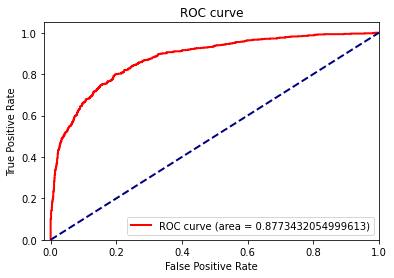

In [224]:
y_pred = bst.predict(dtest)

plt.figure()

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color='r',
            lw=lw, label=f'ROC curve (area = {roc_auc})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

### Setting the Right Threshold

As we have an unbalanced binary class for our delayed response, using 0.5 as the threshold will be problematic when we begin to consider metrics such as precision and recall. To better address this and balance out precision and recall, it will be beneficial to use the F1-Score:

$$ F_1 = 2 \frac{precision * recall}{precision+recall} $$


In [249]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

beta = 1

f_score = (1 + beta**2)*precision*recall/(beta**2*precision + recall)
ix = np.argmax(f_score) #get threshold with highest F-score

y_pred_labels = list(np.where(np.array(y_pred) > thresholds[ix], 1, 0))

print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], f_score[ix]))
print(confusion_matrix(y_test, y_pred_labels))


Best Threshold=0.147839, F-Score=0.713
[[1383  247]
 [ 182  531]]


### Saving the Model to be Used

The components we will be needing to pickle save will be the model itself and the encoders. This makes way for future need to do predictions. Ofcourse, the metrics calculations will be the same as well. More importantly, we also need to make sure we **keep track of the threshold that maximises our F1 score**. The way we do this can just be by the model file name.

In [260]:
model_name = f"{date.today().strftime('%Y%m%d')}_t_{thresholds[ix]}".replace(".", "_")
iata_encoder_name = f"{date.today().strftime('%Y%m%d')}_iata_encoder"
dest_encoder_name = f"{date.today().strftime('%Y%m%d')}_dest_encoder"

pickle.dump(bst, open(f'./models/{model_name}.pkl', "wb"))
pickle.dump(iata_encoder, open(f'./models/{iata_encoder_name}.pkl', "wb"))
pickle.dump(dest_encoder, open(f'./models/{dest_encoder_name}.pkl', "wb"))